# EDA + Preprocessing

In [9]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import tensorflow as tf
sns.set()

## Dataset

Our dataset is located at [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315). The dataset was originally created based on [this publication](https://nihcc.app.box.com/v/ChestXray-NIHCC/file/256057377774). This chest X-ray database (CXR8) was constructed due to addressing a need for hospital-scale radiological imaging presenting realistic clinical and methodological challenges, and present a public database for uses in disease analyses.

First, we can take a look at details of our patient data by checking the Data Entry csv file showing general characteristics of each subject's image. Most importantly we will see the finding labels, which are generated via NLP from radiologist reports. We can also see more details including patient age/sex, the view position of the image (i.e. Posterior-Anterior), and the original image's dimensions. 

In [10]:
patient_data = pd.read_csv("../Data_Entry_2017_v2020.csv")
patient_data.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [11]:
patient_data['Finding Labels'].head(5)

0              Cardiomegaly
1    Cardiomegaly|Emphysema
2     Cardiomegaly|Effusion
3                No Finding
4                    Hernia
Name: Finding Labels, dtype: object

In [12]:
patient_data['Patient ID'].tail(1)

112119    30805
Name: Patient ID, dtype: int64

Our patient data totals to 112,120 total medical images for 30,805 unique patients. These images have been collected from patients spanning 1992 - 2015 from the clinical PACS database at NIHCC (National Institutes of Health Clinical Center) in which image labels are mined via NLP from radiology reports. The text-mined disease labels are expectedly >90% accuracy. Images are labeled as XXX_YYY.png, where XXX represents patient ID and YYY represents the CXR ID (or followup) of that patient.

Our finding labels include a total of 14 of the most common thoracic pathologies:

Atelectasis, Cardiomegaly, Effusion, Infiltration, Mass, Nodule, Penumonia, Penumothorax, Consolidation, Edema, Emphysema, Fibrosis, Pleural Thickening, and Hernia.

Using our first patient (57M) as an example, we can see their first CXR (00000001_000.png) which is labeled with cardiomegaly. 

<img src="../images/00000001_000.png" alt="U-net Image" width="300" align="middle"/>


## Considerations

We want to make sure that our machine learning model(s) recognize specific features and pathologies, rather than simply memorize patient-specific attributes. To ensure this, while splitting our dataset into training, testing, and validation sets we will make sure our all of the images of each patient belong to a single set (i.e. no patient should have one image in a training set and another image in a validation or testing set). 

This data is already divided accordingly to text files test_list.txt and train_val_list.txt associated with the CXR8 dataset as recommended by the authors. Using a structured split dataset as referenced by [a publication analyzing pruning impact on medical image classifiers](https://arxiv.org/pdf/2308.09180), we have three labeled datasets respecting the patient division structured with one-hot-encoded columns representing pathologies.

Each set also contains a column for Subject ID, Image ID, and for No Findings (i.e. none of the 14 pathologies show up). Before we explore the training set in particular to assess data distribution, summaries, and structure we make sure to remove the disease features outside the 14 pathologies being focused on. 


In [87]:
# Patient training data
# Removing unneeded pathologies from training, validation, and test sets

pt_train = pd.read_csv("miccai2023_nih-cxr-lt_labels_train.csv")
pt_train = pt_train.drop(columns=['Pneumoperitoneum', 
                                  'Pneumoperitoneum',
                                  'Pneumomediastinum', 
                                  'Subcutaneous Emphysema',
                                  'Tortuous Aorta', 
                                  'Calcification of the Aorta'],
                        axis = 0)
pt_valid = pd.read_csv("miccai2023_nih-cxr-lt_labels_val.csv").drop(columns=['Pneumoperitoneum', 
                                  'Pneumoperitoneum',
                                  'Pneumomediastinum', 
                                  'Subcutaneous Emphysema',
                                  'Tortuous Aorta', 
                                  'Calcification of the Aorta'],
                        axis = 0)
pt_test = pd.read_csv("miccai2023_nih-cxr-lt_labels_test.csv").drop(columns=['Pneumoperitoneum', 
                                  'Pneumoperitoneum',
                                  'Pneumomediastinum', 
                                  'Subcutaneous Emphysema',
                                  'Tortuous Aorta', 
                                  'Calcification of the Aorta'],
                        axis = 0)

pt_train.head()
# pt_valid.head()
# pt_test.head()

,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural Thickening,Pneumonia,Pneumothorax,No Finding,subj_id
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
4,00000004_000.png,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,4


In [14]:
pt_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78506 entries, 0 to 78505
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  78506 non-null  object
 1   Atelectasis         78506 non-null  int64 
 2   Cardiomegaly        78506 non-null  int64 
 3   Consolidation       78506 non-null  int64 
 4   Edema               78506 non-null  int64 
 5   Effusion            78506 non-null  int64 
 6   Emphysema           78506 non-null  int64 
 7   Fibrosis            78506 non-null  int64 
 8   Hernia              78506 non-null  int64 
 9   Infiltration        78506 non-null  int64 
 10  Mass                78506 non-null  int64 
 11  Nodule              78506 non-null  int64 
 12  Pleural Thickening  78506 non-null  int64 
 13  Pneumonia           78506 non-null  int64 
 14  Pneumothorax        78506 non-null  int64 
 15  No Finding          78506 non-null  int64 
 16  subj_id             78

In [135]:
pathology_cols = list(pt_train.drop(['id','subj_id'], axis = 1).keys())
pathology_cols

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural Thickening',
 'Pneumonia',
 'Pneumothorax',
 'No Finding']

We can see that there are no null values in our dataset, and that our data types are standardized (one-hot-encoded as binary int64 values).

Now we'll focus on the class distributions for each type of pathology.

The class Atelectasis has 7587 samples
The class Cardiomegaly has 1590 samples
The class Consolidation has 2626 samples
The class Edema has 1283 samples
The class Effusion has 7919 samples
The class Emphysema has 1327 samples
The class Fibrosis has 1138 samples
The class Hernia has 130 samples
The class Infiltration has 12739 samples
The class Mass has 3689 samples
The class Nodule has 4359 samples
The class Pleural Thickening has 1998 samples
The class Pneumonia has 806 samples
The class Pneumothorax has 2432 samples
The class No Finding has 44625 samples


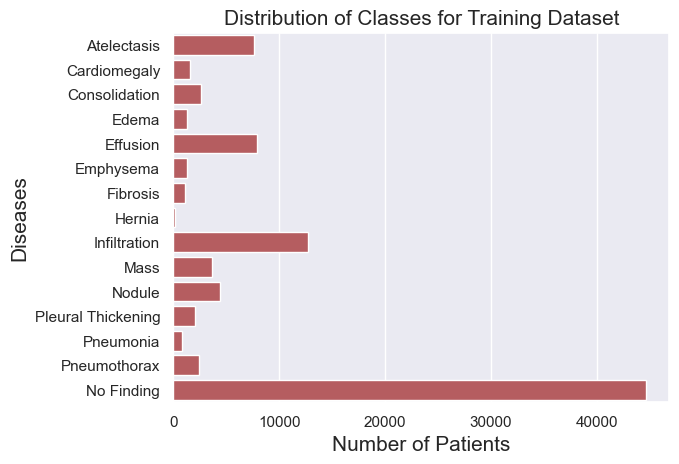

In [21]:
# Count up the number of instances of each class (drop non-class columns from the counts)
class_counts = pt_train.sum().drop(['id','subj_id'])

for column in class_counts.keys():
    print(f"The class {column} has {pt_train[column].sum()} samples")

# Plotting pathology count distributions
sns.barplot(x = class_counts.values, y = class_counts.index, color='r')
plt.title('Distribution of Classes for Training Dataset', fontsize=15)
plt.xlabel('Number of Patients', fontsize=15)
plt.ylabel('Diseases', fontsize=15)
plt.show()

Based on these distributions, it is clear that we have a significantly imbalanced dataset showing a majority of images presenting with no findings. We can also see that hernias are the least represented pathology with only 130 total samples. Turning to literature, we can see that the [following publication](https://arxiv.org/pdf/2208.13365) addresses clinical data imbalances. In particular, it discusses possible avenues to address the distribution imbalance with majority of patients present without any of the 14 indicated pathologies.

### Ensuring no patient overlap

As mentioned previously, we do not want patient overlap--this way, our model is trained on specific pathological features rather than specific patient features. We can check for overlap between our training, validation and test sets:

In [96]:
ids_train_set = set(pt_train.subj_id.values)
ids_valid_set = set(pt_valid.subj_id.values)
ids_test_set = set(pt_test.subj_id.values)
patient_overlap = list(ids_train_set.intersection(ids_valid_set))
patient_overlap_test = list(ids_test_set.intersection(ids_valid_set))
n_overlap = len(patient_overlap)
n_overlap_test = len(patient_overlap_test)
print(f'There are {n_overlap} Patient IDs in both the training and validation sets')
print(f'There are {n_overlap_test} Patient IDs in both the validation and test sets')

There are 0 Patient IDs in both the training and validation sets
There are 0 Patient IDs in both the validation and test sets


## Checking a single CXR


The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.5025 and the standard deviation is 0.2644


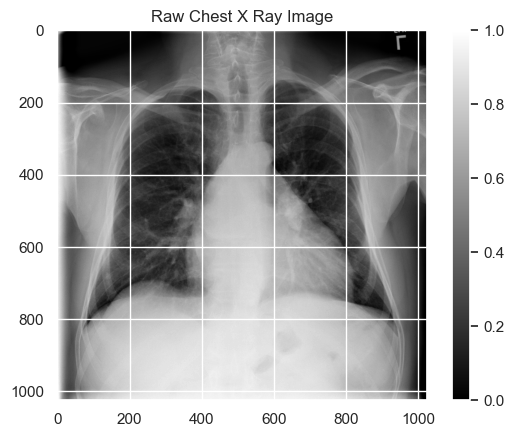

In [27]:
# Looking at first image in depth

img_dir = '../images'

sample_img = pt_train.id[0]
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

### Image Preprocessing

We need to process images for our convolutional neural networks to train more effectively. The images should be normalized and scaled for the CNN to converge faster. Moreover, our limited dataset size (especially for representation on less common pathologies like hernias) can be effectively increased by data augmentation to reduce chances of overfitting. However, we do need to keep in mind that not all augmentation is appropriate--for example, flipping an image (across the Y axis) would place the heart on the wrong side of the patient, which would represent incorrect anatomy for our network to be trained on. 

Generally speaking, properly preprocessed images should help highlight our essential features while minimizing less relevant ones (ie related to noise, extreme brightness, etc). We start by looking at our first image in greater depth:

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.5025 and the standard deviation is 0.2644


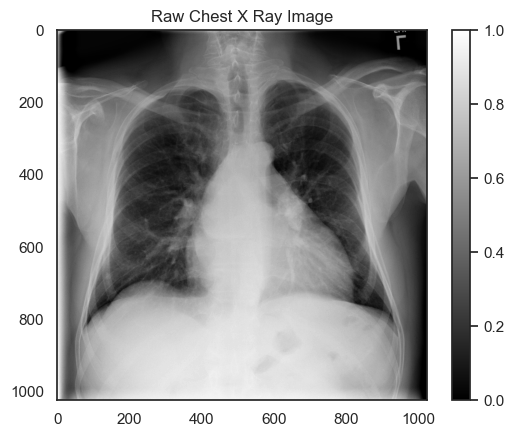

In [50]:
# Looking at first image in depth

img_dir = '../images'

sample_img = pt_train.id[0]
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

Our images are largely 1024 x 1024 in size, but we don't have standardizes mean/StD values for pixel intensity. We can create a list of file paths and multi-hot label vectors, incorporate a tf.data.Dataset using `from_tensor_slices` and map out each image to perform per-image normalization. We can batch and prefetch the dataset for performance.

In [79]:
image_files = pt_train['id'].values
labels = pt_train[pathology_cols].values
dataset = tf.data.Dataset.from_tensor_slices((image_files, labels))
# This dataset gives us .png + label pairs

In [43]:
IMG_SIZE = (1024, 1024)

def load_and_preprocess_image(filename, label):
    # 1) Construct full path
    full_path = tf.strings.join([img_dir, filename], separator=os.path.sep)
    
    # 2) Load and decode the image
    image_bytes = tf.io.read_file(full_path)
    image = tf.io.decode_image(image_bytes, channels=1, expand_animations=False)
    
    # 3) Resize
    image = tf.image.resize(image, IMG_SIZE)
    
    # 4) Convert to float
    image = tf.cast(image, tf.float32)
    
    # 5) Samplewise normalization => mean=0, std=1
    mean, var = tf.nn.moments(image, axes=[0, 1, 2])  # entire image
    std = tf.sqrt(var)
    image = (image - mean) / tf.maximum(std, 1e-7) # avoid division by 0
    
    return image, label # returns normalized image + label

In [52]:
BATCH_SIZE = 8

train_dataset = (
    dataset
    .shuffle(buffer_size=len(pt_train), reshuffle_each_iteration=True) # randomize order of pairs 
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # normalizes each image
    .batch(BATCH_SIZE) # grouping to 8 images/labels each
    .prefetch(tf.data.AUTOTUNE) # more efficient training
)

# we can iterate through dataset: for batch_images, batch_labels in train_dataset: ...
# or with a keras model, train on this dataset directly
# or manually fetch batches (below)

Now we can fetch batches and take a look at different images--we can see that our mean and standard deviations for pixels are 0 and 1 respectively. 

Batch of images shape: (8, 1024, 1024, 1)
Batch of labels shape: (8, 15)
Sample image stats: mean=-0.0000, std=1.0000


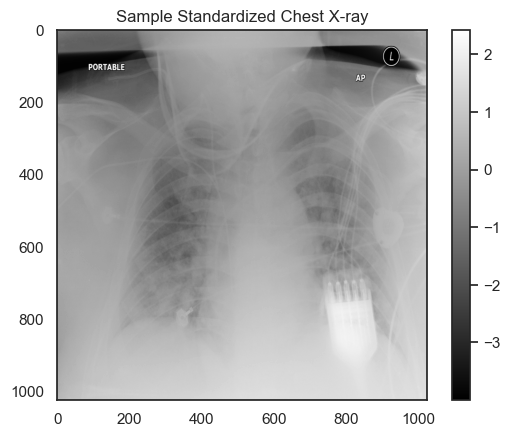

Corresponding label vector: [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]


In [78]:
# Fetch one batch
images_batch, labels_batch = next(iter(train_dataset))
print("Batch of images shape:", images_batch.shape)  # (8, 1024, 1024, 1)
print("Batch of labels shape:", labels_batch.shape)  # (8, 15)

# First image in this batch
sample_image = images_batch[0].numpy()  # shape: (320, 320, 1)
sample_label = labels_batch[0].numpy()  # shape: (14,)

print(f"Sample image stats: mean={sample_image.mean():.4f}, "
      f"std={sample_image.std():.4f}")

sns.set_style("white")
plt.imshow(sample_image.squeeze(), cmap="gray")
plt.colorbar()
plt.title("Sample Standardized Chest X-ray")
plt.show()

print("Corresponding label vector:", sample_label)

### Data Imbalance Considerations

As previously discussed, we need to account for data imbalances--particularly due to the fact that a significant majority of CXRs present with no findings. In order to create an effective model or CNN, we need to consider weighted loss functions to address this imbalance. We want to train our model with an evenly balanced dataset so positive and negative training cases are contributing equally to the loss. 

Using a normal cross-entropy loss function with an unbalanced dataset (like the one we have) results in more prioritization in the majority class (ie negative here) as it contributes more to the loss. 

One way to change this contribution inequality is multiplying each example from each class by class-specific weight factors so overall contribution of each class is the same.

After applying these weightings, we implement a loss function:
$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$


In [106]:
def compute_class_freqs(labels):
    # pos/neg freq for each class given labels
    N = labels.shape[0]
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1.0 - positive_frequencies
    return positive_frequencies, negative_frequencies

In [110]:
freq_pos, freq_neg = compute_class_freqs(labels)
print("Positive frequencies:", freq_pos)
print("Negative frequencies:", freq_neg)

Positive frequencies: [0.09664229 0.02025323 0.03344967 0.0163427  0.10087127 0.01690317
 0.01449571 0.00165592 0.16226785 0.04699004 0.05552442 0.02545028
 0.01026673 0.03097852 0.56842789]
Negative frequencies: [0.90335771 0.97974677 0.96655033 0.9836573  0.89912873 0.98309683
 0.98550429 0.99834408 0.83773215 0.95300996 0.94447558 0.97454972
 0.98973327 0.96902148 0.43157211]


We can look at our positive vs negative contribution ratios per each pathology:

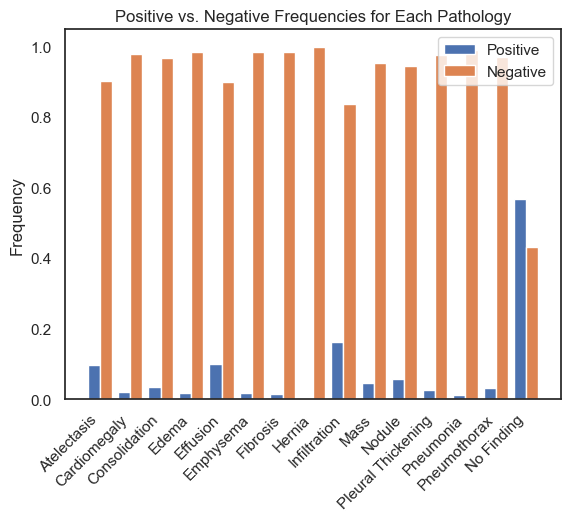

In [130]:
# Plot pos frequencies
plt.bar(
    x - bar_width/2,        # Shift the bars to the left by half the bar width
    freq_pos,
    width=bar_width,
    label='Positive',
)

# Plot neg frequencies
plt.bar(
    x + bar_width/2,        # Shift the bars to the right by half the bar width
    freq_neg,
    width=bar_width,
    label='Negative',
)
plt.xticks(x, pathologies, rotation=45, ha='right')
plt.ylabel('Frequency')
plt.title('Positive vs. Negative Frequencies for Each Pathology')
plt.legend()

It's clear here that there's a significantly higher contribution by negative cases than positive cases, with the exception of No Finding (representing normal).

In [132]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

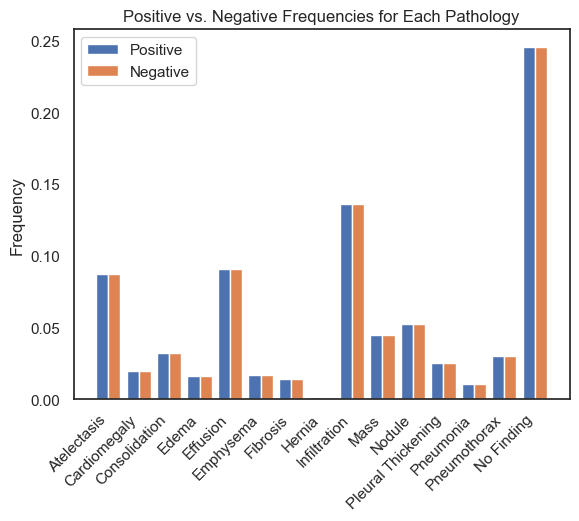

In [134]:
# Plot pos frequencies
plt.bar(
    x - bar_width/2,        # Shift the bars to the left by half the bar width
    pos_contribution,
    width=bar_width,
    label='Positive',
)

# Plot neg frequencies
plt.bar(
    x + bar_width/2,        # Shift the bars to the right by half the bar width
    neg_contribution,
    width=bar_width,
    label='Negative',
)
plt.xticks(x, pathologies, rotation=45, ha='right')
plt.ylabel('Frequency')
plt.title('Positive vs. Negative Frequencies for Each Pathology')
plt.legend()

We create our `get_weighted_loss` function that calculates weighted loss per batch--for multi-class loss, we add up average loss for each individual class. To aavoid possible numerical errors (ie if predicted value is 0), we add a small value $\epsilon$ to predicted values prior to taking their log values.

In [ ]:
def get_weighted_loss(pos_weights, neg_weights, episilon = 1e-7):
    # return weighted loss function given pos/neg weights (arr for each class, size)
    def weighted_loss(y_train, y_pred):
        # return weighted loss value given tensors of true labels/predicted labels
        loss = 0.0
        for i in range(len(pos_weights)):
            pos_loss = -pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon)
            neg_loss = -neg_weights[i] * (1.0 - y_true[:, i]) * K.log(1.0 - y_pred[:, i] + epsilon)
            loss += K.mean(pos_loss + neg_loss)
        return loss
    return weighted_loss

We can start using a pre-trained model loaded directly from Keras

In [137]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model


base_model = DenseNet121(weights='models/nih/densenet.hdf5', include_top=False)


ValueError: The `weights` argument should be either `None` (random initialization), `imagenet` (pre-training on ImageNet), or the path to the weights file to be loaded.